In [ ]:
#| default_exp wind_res


In [ ]:
#| hide
from nbdev.showdoc import *


In [ ]:
#| export
import numpy as np
import pandas as pd
from fastcore.test import *
import importlib.resources
import os
import pkgutil
#import pkg_resources

# Wind resistance coefficients

In order to caluclate the wind resistance experienced by the ship, the wind resistance loading coefficients need to be known. The wind resistance loading coefficients are dependent on the direction the wind is blowing relative to the ship. These coefficients can be found using the following three methods

- Wind tunnel test
- CFD analysis
- Coefficient datasets

The first two approaches are used to create the coefficients specific for the ship. The third option is used when no such simulations have been performed and are based on a set of generic ship designs.

## Load wind resistance coefficients

When there has been no wind tunnel test or CDF analysis the wind resistance coefficients must be found using datasets of look up tables representing generic ship designs for a variety of classes. `pyseatrials` contains the wind loading factor datasets from ITTC. These data sets have been included as 9 dataframes depending on ship type. To load the data frame enter the name of the ship type to load. The available ship types are

- GENERAL_CARGO
- LNG_CARRIER_INT
- CRUISE_FERRY
- 280_KDWT_TANKER
- LNG_CARRIER
- HANDY_SIZE_BULK_CARRIER
- 6800_TEU_CONTAINERSHIP
- MULTI_PURPOSE_CARRIER

In [ ]:
#| export
def load_wind_coefficients(vessel_type:str #The name of the vessel type. Must be one of 9 options
                     ):#returns a data set with where the first column us angle_of_attack in radians, the second is angle_of_attack in degrees, the subsequent columns names ship states
    
    "Loads a data frame of the wind coefficients for a range of angles of attack for the named vessel type"
    resource = vessel_type+".csv"
    package = 'pyseatrials'
    if not importlib.resources.is_resource(package, resource):
        raise FileNotFoundError(f"Python package '{package}' resource '{resource}' not found.")

    with importlib.resources.path(package, resource) as resource_path:
        
        return os.fspath(resource_path)


#res = pkgutil.get_data('sound.effects.cool_effects', 'collection_effects.csv')



In [ ]:
def load_wind_coefficients2(vessel_type:str #The name of the vessel type. Must be one of 9 options
                     ):
        res = pkgutil.get_data('pyseatrials', 'datasets/'+vessel_type+'.csv')
        
        return res
    

In [ ]:
#load_wind_coefficients("GENERAL_CARGO")

FileNotFoundError: Python package 'pyseatrials' resource 'GENERAL_CARGO.csv' not found.

In [ ]:
#| hide
'''
import glob
for x in glob.glob("datasets" + "/*.csv"):
    print(x)
    temp  = pd.read_csv(x)
    temp.insert(loc = 1,column = 'angle_of_attack_degs', value =  temp['angle_of_attack'])
    temp['angle_of_attack'] = np.deg2rad(temp['angle_of_attack'])
    temp.to_csv(x, index = False)
'''

'\nimport glob\nfor x in glob.glob("datasets" + "/*.csv"):\n    print(x)\n    temp  = pd.read_csv(x)\n    temp.insert(loc = 1,column = \'angle_of_attack_degs\', value =  temp[\'angle_of_attack\'])\n    temp[\'angle_of_attack\'] = np.deg2rad(temp[\'angle_of_attack\'])\n    temp.to_csv(x, index = False)\n'

In [ ]:
import pandas as pd

In [ ]:
general_cargo = pd.DataFrame({'angle_of_attack':[0.        , 0.17453293, 0.34906585, 0.52359878, 0.6981317 ,
       0.87266463, 1.04719755, 1.22173048, 1.3962634 , 1.57079633,
       1.74532925, 1.91986218, 2.0943951 , 2.44346095, 2.61799388,
       2.7925268 , 2.96705973, 3.14159265],
            'average':[-0.6 , -0.87, -1.  , -1.  , -0.88, -0.85, -0.65, -0.42, -0.27,
       -0.09,  0.09,  0.49,  0.84,  1.39,  1.47,  1.34,  0.92,  0.82] })

## Interpolate the wind loading coefficients

The dataset loaded previously only contains the load coefficients at specific angles. Interpolation is needed to match these coefficients to the wind acting on the ship.There are many ways to interpolate these values, `pyseatrials` uses simple linear interpolation. Linear interpolation has been chosen over other approaches as it can be vectorised and reduces package dependencies. In addition the ultimate difference, between e.g. linear vs spline interpolation, in resistive force will be small compared to the magnitude of forces acting on the ship.

In [ ]:
#| export
def interpolate_cx(df, #dataframe of the wind resistance dataset
                   relative_wind_direction:float, #The angle of the wind relative to the ship [rads]
                   ship_state:str #The state of the ship the resistance should be evaluated in. Chosen from the columns of the wind resistance datasets
)->float: # The dimensionless wind resistance coefficient
    
    "Find a linearly interpolated value for wind resistance coefficient"
    
    return np.interp(relative_wind_direction, df.angle_of_attack, df[ship_state])

Using the example of the general cargo ship using four different wind direction scenarios (0, 55, 180, 280 degrees) we get the interpolated loading coefficients.
Some ships have data for different states such as 'laden' and 'ballast' the General Cargo dataset only has a single state 'average'.

In [ ]:
degs = [0, 55, 120, 180 ]
rads = np.deg2rad(degs) #convert the degrees to radians
cx_vals = interpolate_cx(general_cargo, rads, 'average')
print(cx_vals)

[-0.6  -0.75  0.84  0.82]


In [ ]:
#| hide
#sanity check tests
test_df = pd.DataFrame({'angle_of_attack': [0, 2], 'cx':[0, 100]})
test_eq(interpolate_cx(test_df, 0, 'cx'), 0)
test_eq(interpolate_cx(test_df, 2, 'cx'), 100)

The wind resistance coefficients can then be used to find the actual wind resistance experienced by the ship

In [ ]:
from pyseatrials.general import *

In [ ]:
wind_resistance_linear = wind_resistance(air_density = 1.2,
                   wind_resistance_coef_rel = cx_vals,
                   wind_resistance_coef_zero = cx_vals[0],
                   area = 500,
                   relative_wind_speed = 20,
                   sog = 10)

#convert to kN
resistance_linear_kN = np.round(wind_resistance_linear/1000)
print(resistance_linear_kN )

[-54. -72. 119. 116.]


Other interpolations methods can be used such as spline interpolation from the `scipy` library.

In [ ]:
from scipy.interpolate import make_interp_spline

In [ ]:
cx_spline = make_interp_spline(general_cargo['angle_of_attack'], general_cargo['average'] )


The difference between the load coefficients produced by the two models can be shown in the plot below. Across the full range there is almost no difference.

In [ ]:
import matplotlib.pyplot as plt

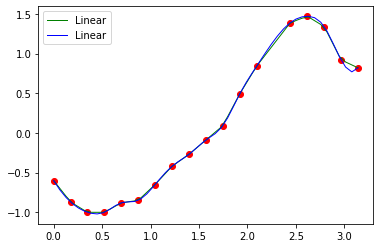

In [ ]:
xs = np.linspace(-3, 3, 100)
xvals = np.linspace(0, np.pi, 50)
yinterp_lin = np.interp(xvals, general_cargo['angle_of_attack'], general_cargo['average'])
yinterp_spline = cx_spline(xvals)
plt.plot(general_cargo['angle_of_attack'], general_cargo['average'], 'ro')
plt.plot(xvals, yinterp_lin,'g-', lw=1, label='Linear')
plt.plot(xvals, yinterp_spline,'b-', lw=1, label='Linear')
plt.legend(loc='best')
plt.show()

The difference in terms of actual resistive force between linear and spline interpolation is also very small.

In [ ]:
wind_resistiance_spline = wind_resistance(air_density = 1.2,
                   wind_resistance_coef_rel = cx_spline(rads),
                   wind_resistance_coef_zero = cx_spline(rads)[0],
                   area = 500,
                   relative_wind_speed = 20,
                   sog = 10)
#convert to kN
resitance_spline_kN = np.round(wind_resistiance_spline/1000)

#difference in wind resistance between the two models in kN
print('difference in kN between the two interpolation methods for all 4 angles of attack '+str(resistance_linear_kN - resitance_spline_kN))

difference in kN between the two interpolation methods for all 4 angles of attack [0. 2. 0. 0.]
